## Data Loading


In [125]:
#importing necessery libraries for future analysis of the dataset
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as plt
import seaborn as sns
import time
import numpy as np


In [228]:
"""
Read data Ubahn
ubahn1 = pd.read_json("Data/Ubahn/Json/ubahn1.json")
ubahn2 = pd.read_json("Data/Ubahn/Json/ubahn2.json")
ubahn3 = pd.read_json("Data/Ubahn/Json/ubahn3.json")
ubahn4 = pd.read_json("Data/Ubahn/Json/ubahn4.json")
ubahn5 = pd.read_json("Data/Ubahn/Json/ubahn5.json")
ubahn6 = pd.read_json("Data/Ubahn/Json/ubahn6.json")
ubahn7 = pd.read_json("Data/Ubahn/Json/ubahn7.json")
"""

## Function

### Transform files

In [231]:
#Tranform accelerometer and gyroscope data to one dataframe
def transform_data_acceleration(file, format, type):
    if format == 'json':
        df = pd.read_json(file)
    else:
        df = pd.read_csv(file)   
    acce = df[df['sensor'] == 'Accelerometer']
    acce.reset_index(drop=True, inplace=True)   
    acce = acce.drop(columns =['sensor', 'relativeAltitude', 'pressure', 'altitude', 'speedAccuracy', 'bearingAccuracy', 'latitude', 'altitudeAboveMeanSeaLevel', 'bearing', 'horizontalAccuracy', 'verticalAccuracy', 'longitude', 'speed', 'version', 'device name', 'recording time', 'platform', 'appVersion', 'device id', 'sensors', 'sampleRateMs', 'yaw', 'qx', 'qz', 'roll', 'qw', 'qy', 'pitch'])

    gyro = df[df['sensor'] == 'Gyroscope']
    gyro.reset_index(drop=True, inplace=True)   
    gyro = gyro.drop(columns = ['sensor', 'relativeAltitude', 'pressure', 'altitude', 'speedAccuracy', 'bearingAccuracy', 'latitude', 'altitudeAboveMeanSeaLevel', 'bearing', 'horizontalAccuracy', 'verticalAccuracy', 'longitude', 'speed', 'version', 'device name', 'recording time', 'platform', 'appVersion', 'device id', 'sensors', 'sampleRateMs', 'yaw', 'qx', 'qz', 'roll', 'qw', 'qy', 'pitch'])
    
    for df in [gyro, acce]:
         df.index = pd.to_datetime(df['time'], unit = 'ns',errors='ignore')
         df.drop(columns=['time'], inplace=True)
    #df_new = pd.merge(loc, gyro, suffixes=('_loc', '_gyro'), on='time')
    df_new = gyro.join(acce, lsuffix = '_gyro', rsuffix = '_acce', how = 'outer').interpolate()
   
    #df_new = pd.merge(pd.merge(loc, gyro, suffixes=('_loc', '_gyro'), on='time'), acce, suffixes=('', '_acce'), on='time')
    df_new['Type'] = type
    return df_new

In [234]:
ubahn1_df = transform_data_acceleration('Data/Ubahn/Json/ubahn1.json','json', 'ubahn')
ubahn1_df.head()

,seconds_elapsed_gyro,z_gyro,y_gyro,x_gyro,seconds_elapsed_acce,z_acce,y_acce,x_acce,Type
time,,,,,,,,,
2023-05-24 06:22:01.646028032,0.061028,-0.065886,-0.131727,-0.000490,0.061028,0.754174,0.097933,-0.078810,ubahn
2023-05-24 06:22:01.655958784,0.070959,-0.083643,-0.161329,-0.052177,0.070959,0.614281,0.006319,0.001526,ubahn
2023-05-24 06:22:01.665890816,0.080891,-0.090577,-0.155885,-0.080811,0.080891,0.424520,-0.053153,0.010451,ubahn
2023-05-24 06:22:01.675822080,0.090822,-0.081968,-0.098422,-0.091392,0.090822,0.249951,-0.122709,0.029735,ubahn
2023-05-24 06:22:01.685754112,0.100754,-0.070894,-0.036236,-0.088838,0.100754,0.161045,-0.135531,-0.023734,ubahn


In [226]:
#Tranform accelerometer and gyroscope data to one dataframe
def transform_data_location(file, format, type):
    if format == 'json':
        df = pd.read_json(file)
    else:
        df = pd.read_csv(file)   

    location = df[df['sensor'] == 'Location']
    location.reset_index(drop=True, inplace=True)
    location = location.drop(columns = ['sensor', 'z', 'y', 'x', 'relativeAltitude', 'pressure', 'version', 'device name', 'recording time', 'platform', 'appVersion', 'device id', 'sensors', 'sampleRateMs', 'yaw', 'qx', 'qz', 'roll', 'qw', 'qy', 'pitch'])

    
    
    location.index = pd.to_datetime(location['time'], unit = 'ns',errors='ignore')
    location.drop(columns=['time'], inplace=True)
    location['Type'] = type
    return location

In [235]:
ubahn1_df = transform_data_location('Data/Ubahn/Json/ubahn1.json','json', 'ubahn')
ubahn1_df.head()

,seconds_elapsed,altitude,speedAccuracy,bearingAccuracy,latitude,altitudeAboveMeanSeaLevel,bearing,horizontalAccuracy,verticalAccuracy,longitude,speed,Type
time,,,,,,,,,,,,
2023-05-24 06:21:56.020563968,-5.564436,543.763552,5.484079,14.670308,49.418010,498.173552,119.543534,51.911914,9.447181,11.119809,16.866673,ubahn
2023-05-24 06:22:01.643231744,0.058232,543.763552,5.484079,14.670308,49.418010,498.173552,119.543534,51.911914,9.447181,11.119809,16.866673,ubahn
2023-05-24 06:22:05.998951424,4.413951,376.908325,2.040000,-1.000000,49.417238,331.318325,-1.000000,92.711189,16.000000,11.107248,0.000000,ubahn
2023-05-24 06:22:06.998939904,5.413940,372.446045,1.990000,-1.000000,49.417234,326.856045,-1.000000,57.902940,4.000000,11.107306,0.000000,ubahn
2023-05-24 06:22:07.998926592,6.413927,372.965454,1.940000,85.151661,49.417372,327.375454,350.507812,48.842302,6.000000,11.107352,0.000000,ubahn


### Test idee

In [25]:
#Merge features into df
ubahn1_df = pd.merge(pd.merge(loc_ubahn1, gy_ubahn1, suffixes=('_loc', '_gyro'), on='time'), acc_ubahn1, suffixes=('', '_acce'), on='time')
ubahn2_df = pd.merge(pd.merge(loc_ubahn2, gy_ubahn2, suffixes=('_loc', '_gyro'), on='time'), acc_ubahn2, suffixes=('', '_acce'), on='time')
ubahn3_df = pd.merge(pd.merge(loc_ubahn3, gy_ubahn3, suffixes=('_loc', '_gyro'), on='time'), acc_ubahn3, suffixes=('', '_acce'), on='time')
ubahn4_df = pd.merge(pd.merge(loc_ubahn4, gy_ubahn4, suffixes=('_loc', '_gyro'), on='time'), acc_ubahn4, suffixes=('', '_acce'), on='time')
ubahn5_df = pd.merge(pd.merge(loc_ubahn5, gy_ubahn5, suffixes=('_loc', '_gyro'), on='time'), acc_ubahn5, suffixes=('', '_acce'), on='time')
ubahn6_df = pd.merge(pd.merge(loc_ubahn6, gy_ubahn6, suffixes=('_loc', '_gyro'), on='time'), acc_ubahn6, suffixes=('', '_acce'), on='time')
ubahn7_df = pd.merge(pd.merge(loc_ubahn7, gy_ubahn7, suffixes=('_loc', '_gyro'), on='time'), acc_ubahn7, suffixes=('', '_acce'), on='time')


In [22]:
ubahn7_df.head()

,seconds_elapsed_loc,altitude,speedAccuracy,bearingAccuracy,latitude,altitudeAboveMeanSeaLevel,bearing,horizontalAccuracy,verticalAccuracy,longitude,speed,seconds_elapsed_gyro,z,y,x,seconds_elapsed,z_acce,y_acce,x_acce
time,,,,,,,,,,,,,,,,,,,
2023-05-23 11:01:54,0.066939,365.348587,-1,-1,49.463329,318.037323,-1,232.654174,16.735189,11.080577,-1,0.092214,-0.023959,-0.127546,-0.212151,0.092214,0.330311,0.081560,0.117979
2023-05-23 11:01:54,0.066939,365.348587,-1,-1,49.463329,318.037323,-1,232.654174,16.735189,11.080577,-1,0.092214,-0.023959,-0.127546,-0.212151,0.102145,0.343539,0.054304,0.119370
2023-05-23 11:01:54,0.066939,365.348587,-1,-1,49.463329,318.037323,-1,232.654174,16.735189,11.080577,-1,0.092214,-0.023959,-0.127546,-0.212151,0.112077,0.220420,0.024262,0.079610
2023-05-23 11:01:54,0.066939,365.348587,-1,-1,49.463329,318.037323,-1,232.654174,16.735189,11.080577,-1,0.092214,-0.023959,-0.127546,-0.212151,0.122009,0.215372,0.007668,0.057095
2023-05-23 11:01:54,0.066939,365.348587,-1,-1,49.463329,318.037323,-1,232.654174,16.735189,11.080577,-1,0.092214,-0.023959,-0.127546,-0.212151,0.131940,0.197260,0.057529,0.020442


### Compute features of the data based on 3 minutes temporal window.

In [39]:
#Cut data into windows of 3 minutes
def cut_into_windows(df):
    df = df.resample('3T').sum()
    # Create a new DataFrame with 'time' as the index
    pivot = pd.pivot_table(df, 
                           values=['speed'], 
                           index='time', 
                           aggfunc=('min','mean', 'max'))
    # Resample the DataFrame to 3-minute intervals and calculate the sum
    #tumbling = pivot.resample('3T').sum()
    return pivot

In [25]:
#Combine 3-minutes windows data into one DataFrame
def combine_into_df(dfs):
    combined_df = pd.concat([cut_into_windows(df) for df in dfs])  # Apply cut_into_window to each DataFrame and concatenate them
    combined_df.reset_index(drop=True, inplace=True)  # Reset the index of the combined DataFrame
    return combined_df

In [44]:
#Apply on function
loc_ubahn = combine_into_df(loc_ubahn)
loc_ubahn.head(22)

,max,mean,min
0,16.866673,16.866673,16.866673
1,16.866673,16.866673,16.866673
2,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000
5,0.610000,0.610000,0.610000
6,0.690000,0.690000,0.690000
7,0.570000,0.570000,0.570000
8,0.170000,0.170000,0.170000
9,0.450000,0.450000,0.450000


In [198]:
#Add new column for traffic type
for i in range(len(loc_ubahn)):
  loc_ubahn['Type'] = 'ubahn'
loc_ubahn.head(22)

,time,amin,amax,mean,Type
,,speed,speed,speed,
0,2023-05-24 06:21:00,833.836923,833.836923,833.836923,ubahn
1,2023-05-24 06:24:00,1358.259090,1358.259090,1358.259090,ubahn
2,2023-05-23 11:18:00,-1.000000,-1.000000,-1.000000,ubahn
3,2023-05-23 11:21:00,-9.000000,-9.000000,-9.000000,ubahn
4,2023-05-23 11:24:00,-2.000000,-2.000000,-2.000000,ubahn
5,2023-05-24 06:06:00,-1.000000,-1.000000,-1.000000,ubahn
6,2023-05-24 06:09:00,-15.000000,-15.000000,-15.000000,ubahn
7,2023-05-24 06:12:00,-7.000000,-7.000000,-7.000000,ubahn
8,2023-05-24 12:15:00,0.000000,0.000000,0.000000,ubahn


### Stream live data from app to website

In [ ]:
import dash
from dash.dependencies import Output, Input
from dash import dcc, html, dcc
from datetime import datetime
import json
import plotly.graph_objs as go
from collections import deque
from flask import Flask, request

server = Flask(__name__)
app = dash.Dash(__name__, server=server)

MAX_DATA_POINTS = 1000
UPDATE_FREQ_MS = 100

time = deque(maxlen=MAX_DATA_POINTS)
accel_x = deque(maxlen=MAX_DATA_POINTS)
accel_y = deque(maxlen=MAX_DATA_POINTS)
accel_z = deque(maxlen=MAX_DATA_POINTS)

app.layout = html.Div(
	[
		dcc.Markdown(
			children="""
			# Live Sensor Readings
			Streamed from Sensor Logger: tszheichoi.com/sensorlogger
		"""
		),
		dcc.Graph(id="live_graph"),
		dcc.Interval(id="counter", interval=UPDATE_FREQ_MS),
	]
)


@app.callback(Output("live_graph", "figure"), Input("counter", "n_intervals"))
def update_graph(_counter):
	data = [
		go.Scatter(x=list(time), y=list(d), name=name)
		for d, name in zip([accel_x, accel_y, accel_z], ["X", "Y", "Z"])
	]

	graph = {
		"data": data,
		"layout": go.Layout(
			{
				"xaxis": {"type": "date"},
				"yaxis": {"title": "Acceleration ms<sup>-2</sup>"},
			}
		),
	}
	if (
		len(time) > 0
	):  #  cannot adjust plot ranges until there is at least one data point
		graph["layout"]["xaxis"]["range"] = [min(time), max(time)]
		graph["layout"]["yaxis"]["range"] = [
			min(accel_x + accel_y + accel_z),
			max(accel_x + accel_y + accel_z),
		]

	return graph


@server.route("/data", methods=["POST"])
def data():  # listens to the data streamed from the sensor logger
	if str(request.method) == "POST":
		print(f'received data: {request.data}')
		data = json.loads(request.data)
		for d in data['payload']:
			if (
				d.get("name", None) == "accelerometer"
			):  #  modify to access different sensors
				ts = datetime.fromtimestamp(d["time"] / 1000000000)
				if len(time) == 0 or ts > time[-1]:
					time.append(ts)
					# modify the following based on which sensor is accessed, log the raw json for guidance
					accel_x.append(d["values"]["x"])
					accel_y.append(d["values"]["y"])
					accel_z.append(d["values"]["z"])
	return "success"


if __name__ == "__main__":
	app.run_server(port=8000, host="0.0.0.0")

## Data visualizations

In [ ]:
for df in [gy_ubahn1, acc_ubahn1]:
    df.index = pd.to_datetime(df['time'], unit = 'ns')

df = gy_ubahn1.join(acc_ubahn1, lsuffix = '_gyro', rsuffix = '_acce', how = 'outer').interpolate()

df.plot(figsize=(10,5))

In [36]:
#Tracking GPS 
import folium
import pandas as pd

coords = [(row.latitude, row.longitude) for _, row in loc_ubahn1.iterrows()]

my_map = folium.Map(location=[loc_ubahn1.latitude.mean(), loc_ubahn1.longitude.mean()], zoom_start=16)
folium.PolyLine(coords, color="blue", weight=5.0).add_to(my_map)
my_map

<AxesSubplot: xlabel='time', ylabel='speed'>

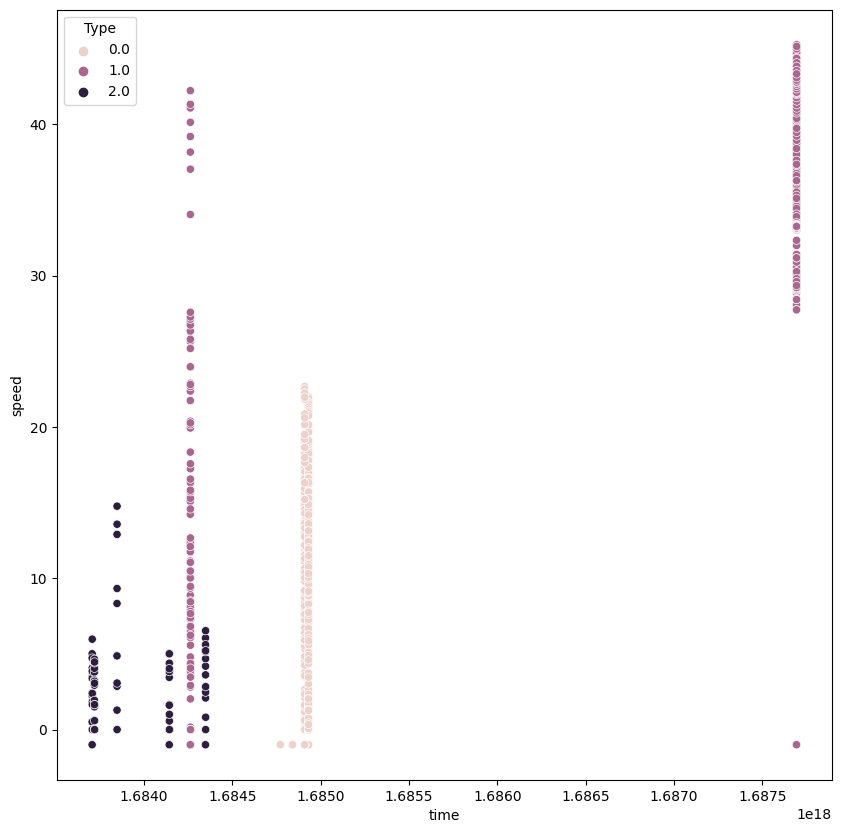

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#Reminder: type_mapping = {'uBahn': '0', 'Auto': '1', 'Fahrrad': '2'}
plt.figure(figsize=(5,5))
sns.scatterplot(x='time', y='speed', hue='Type', data=location_df)

<AxesSubplot: >

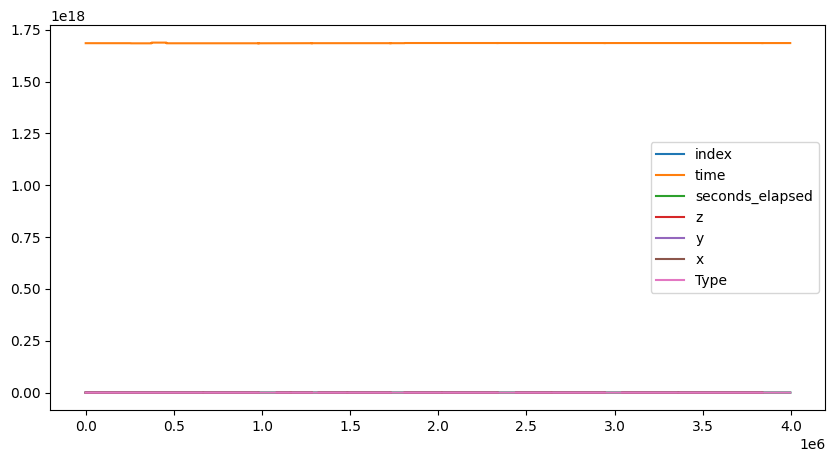

In [ ]:
accelerometer_df.plot(figsize=(10,5))

To read: [Fundamental Techniques of Feature Engineering for Machine Learning](https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114)



## Training the model

### Decision Tree

In [ ]:
#importing decision tree model
from sklearn.metrics import mean_squared_error
import numpy as np 
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor

"""
acc = accuracy_score(test_classes, test_prediction)
df_feature = pd.DataFrame(
            {'accuracy': acc, 'features': features, 'importance': classifier_decision_tree.feature_importances_})
df_feature = df_feature.sort_values(by='importance', ascending=False)
print("ACCURACY : " + str(acc))
print("END TREE")
"""

'\nacc = accuracy_score(test_classes, test_prediction)\ndf_feature = pd.DataFrame(\n            {\'accuracy\': acc, \'features\': features, \'importance\': classifier_decision_tree.feature_importances_})\ndf_feature = df_feature.sort_values(by=\'importance\', ascending=False)\nprint("ACCURACY : " + str(acc))\nprint("END TREE")\n'

In [ ]:
"""
classifier_decision_tree = tree.DecisionTreeClassifier()
classifier_decision_tree.fit(x_train, y_train)
tree_prediction = classifier_decision_tree.predict(x_train)

"""
#defining decision tree regressor
tree_reg=DecisionTreeRegressor()
#feeding X_train and y_train into the regressor
tree_reg.fit(x_train,y_train)
#making predictions on train set
tree_predictions = tree_reg.predict(x_train)


print("Type from Data Set:" )
print(y_train)
print("Type from Prediction: ")
print(tree_predictions)

#getting MSE and RMSE values
tree_mse=mean_squared_error(y_train,tree_predictions)
tree_rmse=np.sqrt(tree_mse)

print("Mean squared error: %.3f" % tree_mse)
print("Root mean squared error: %.3f" % tree_rmse)

Type from Data Set:
[0. 0. 0. ... 0. 0. 0.]
Type from Prediction: 
[0. 0. 0. ... 0. 0. 0.]
Mean squared error: 0.000
Root mean squared error: 0.000


In [ ]:
from sklearn.model_selection import cross_val_score
#performing 10-fold validation
scores=cross_val_score(tree_reg, x_train, y_train, scoring = "neg_mean_squared_error",cv=10)

# skleanr's cross validation expect a utility function, so the greater the better. 
# That is why putting a negative sign
tree_rmse_scores=np.sqrt(-scores)
print("Scores:", tree_rmse_scores)
print("Mean: %.3f" % tree_rmse_scores.mean())
print("STD: %.3f" %  tree_rmse_scores.std())

Scores: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Mean: 0.000
STD: 0.000


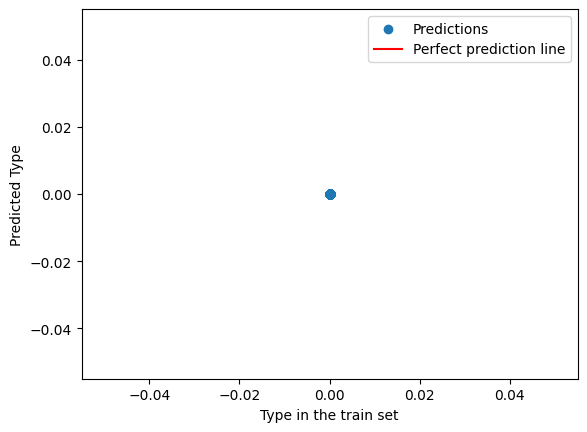

In [ ]:
plt.scatter(y_train,tree_predictions, label='Predictions')
plt.plot(y_train,y_train,'r',label='Perfect prediction line')
plt.xlabel("Type in the train set")
plt.ylabel("Predicted Type")
plt.legend()